In [1]:
# Jupter notebook magic
%matplotlib inline

# Import libraries to work with the data
import os
import sys
from datetime import datetime, timedelta
sys.path.append('../../scripts')

from branca.colormap import linear
import folium

import geopandas as gpd
from geopandas import GeoDataFrame

import h5py
import numpy as np
import pandas as pd
import pyepsg
import scipy.optimize
from shapely.geometry import (Polygon, Point, box)
import xarray as xr
import regionmask

from dask.diagnostics import ProgressBar
    
from GRACE_MASCON.pygrace import (extract_grace, get_mascon_gdf, get_cmwe_trend_analysis)
from LIS import utils as LISutils

import pickle
import matplotlib.pyplot as plt

In [2]:
gracedat = '/Users/lsetiawan/Google Drive/APL_Work/HiMAT/GRACE/GSFC.glb.200301_201607_v02.3b-ICE6G.h5'
lisdat = '/Users/lsetiawan/Google Drive/APL_Work/HiMAT/GRACE/LIS_by_mascon.pkl'

In [3]:
g = extract_grace(gracedat)

Data extracted: 
---
Group: mascon
---
<HDF5 dataset "area_deg": shape (1, 41168), type "<f8">
<HDF5 dataset "area_km2": shape (1, 41168), type "<f8">
<HDF5 dataset "basin": shape (1, 41168), type "<f8">
<HDF5 dataset "elev_flag": shape (1, 41168), type "<f8">
<HDF5 dataset "lat_center": shape (1, 41168), type "<f8">
<HDF5 dataset "lat_span": shape (1, 41168), type "<f8">
<HDF5 dataset "location": shape (1, 41168), type "<f8">
<HDF5 dataset "lon_center": shape (1, 41168), type "<f8">
<HDF5 dataset "lon_span": shape (1, 41168), type "<f8">
---
Group: size
---
<HDF5 dataset "N_arcs": shape (1, 1), type "<f8">
<HDF5 dataset "N_mascon_times": shape (1, 1), type "<f8">
<HDF5 dataset "N_mascons": shape (1, 1), type "<f8">
---
Group: solution
---
<HDF5 dataset "cmwe": shape (41168, 148), type "<f8">
<HDF5 dataset "uncertainty": shape (41168, 148), type "<f8">
---
Group: time
---
<HDF5 dataset "list_ref_days_solution": shape (1, 4128), type "<f8">
<HDF5 dataset "n_ref_days_solution": shape (1,

In [4]:
mascon = g['mascon']
soln = g['solution']
mascon_gdf = get_mascon_gdf(mascon)
## we need to track mascon numbers later, which we get from the index, so make a new "mascon" column
mascon_gdf['mascon'] = mascon_gdf.index

There are 41168 Mascons in this dataset.


In [5]:
mascon_gdf.head()

,area_deg,area_km2,basin,elev_flag,lat_center,lat_span,location,lon_center,lon_span,geometry,mascon
0,1.011449,12453.61,1.1,1.0,78.0,1.0,1.0,289.459459,4.864865,"POLYGON ((291.89189195 77.5, 291.89189195 78.5...",0
1,1.011449,12453.61,1.1,1.0,78.0,1.0,1.0,294.324324,4.864865,"POLYGON ((296.75675675 77.5, 296.75675675 78.5...",1
2,1.011449,12453.61,1.1,1.0,78.0,1.0,1.0,299.189189,4.864865,"POLYGON ((301.62162165 77.5, 301.62162165 78.5...",2
3,1.010152,12437.07,1.1,1.0,79.0,1.0,1.0,293.823529,5.294118,"POLYGON ((296.4705882 78.5, 296.4705882 79.5, ...",3
4,1.010152,12437.07,1.1,1.0,79.0,1.0,1.0,299.117647,5.294118,"POLYGON ((301.7647059 78.5, 301.7647059 79.5, ...",4


## Get LIS DATAFRAME FROM PICKLE

In [6]:
# dropping mask, not needed for graph
lisdf = pickle.load(open(lisdat, 'rb')).reset_index(drop=True, level=0)

In [7]:
# unique mascon id's for region
masconsid = lisdf['mascon'].unique()

In [8]:
masconsid

array([ 8119,  8125,  8118,  8123,  8021,  8122,  7749,  7763,  7748,
        6809,  7765,  7764,  8121,  8127,  8120,  8126,  8124,  9972,
        7744,  7758,  8019,  7745,  7759,  8024,  8018,  8023,  8017,
        8022,  8020,  9977,  7746,  7760,  7762,  7747,  7761,  7776,
        8027,  8028,  8130,  7782,  7801,  7781,  8029,  8035,  8030,
        8036,  8033,  8026,  8025,  8031,  8032,  8034,  8128,  9951,
        7783,  7802,  7803,  8129,  8131,  7800,  7780,  8132,  7795,
        7779,  7798,  7778,  7799,  7777,  7796,  7797,  9960,  8037,
        8038,  8039,  8040,  8041,  8042,  7813,  7814,  7815,  7816,
        8133,  7817,  7820,  7818,  7819,  7821,  7822,  7837,  7854,
        7836,  7840,  7858,  8043,  8048,  8134,  8046,  8051,  8045,
        8050,  8044,  8135,  7832,  7849,  7831,  7833,  7850,  7853,
        7835,  8049,  7857,  7839,  9969,  7852,  7886,  7856,  7855,
        8005,  8004,  8003,  8002,  7851,  7999,  8000,  8052,  8001,
        7866,  7867,

In [9]:
lisdf.head()

,Evap_tavg,Rainf_tavg,Qs_tavg,Snowf_tavg,Qsm_tavg,Qsb_tavg,mascon,waterbal,waterbal_cumulative
time,,,,,,,,,
2001-01-01,0.664089,0.327086,0.003414,0.001830,0.0,0.039482,8119,-0.414137,-0.414137
2001-02-01,0.480099,0.797247,0.008565,0.000107,0.0,0.035661,8119,0.245934,-0.168202
2001-03-01,1.245457,1.288718,0.013990,0.000560,0.0,0.039481,8119,-0.035143,-0.203345
2001-04-01,2.312927,2.370955,0.025592,0.000000,0.0,0.038208,8119,-0.018387,-0.221732
2001-05-01,1.228468,0.722979,0.007807,0.000000,0.0,0.039481,8119,-0.584451,-0.806183


## Make GRACE DATAFRAME IN REGION

In [10]:
## get the mascon time series
t = pd.DataFrame(data = {
    'time': g['time']["ref_days_middle"][0,:]
})

In [11]:
grc_lst = []
for m in masconsid:
    df = pd.DataFrame(data={
        'cmwe': soln['cmwe'][m][:] * 10,
        'mascon': m
    })
    df.index = t['time'].apply(lambda x: datetime(2001,12,31) + timedelta(days=x))
    grc_lst.append(df)

In [12]:
gracedf = pd.concat(grc_lst)

In [13]:
gracedf.head()

,cmwe,mascon
time,,
2003-01-06 12:00:00,-35.208430,8119
2003-02-21 00:00:00,-2.004382,8119
2003-03-16 00:00:00,5.896959,8119
2003-04-15 12:00:00,-42.092590,8119
2003-05-07 12:00:00,-21.614554,8119


## Perform analysis (Single Mascon)

In [14]:
masconid = 6777

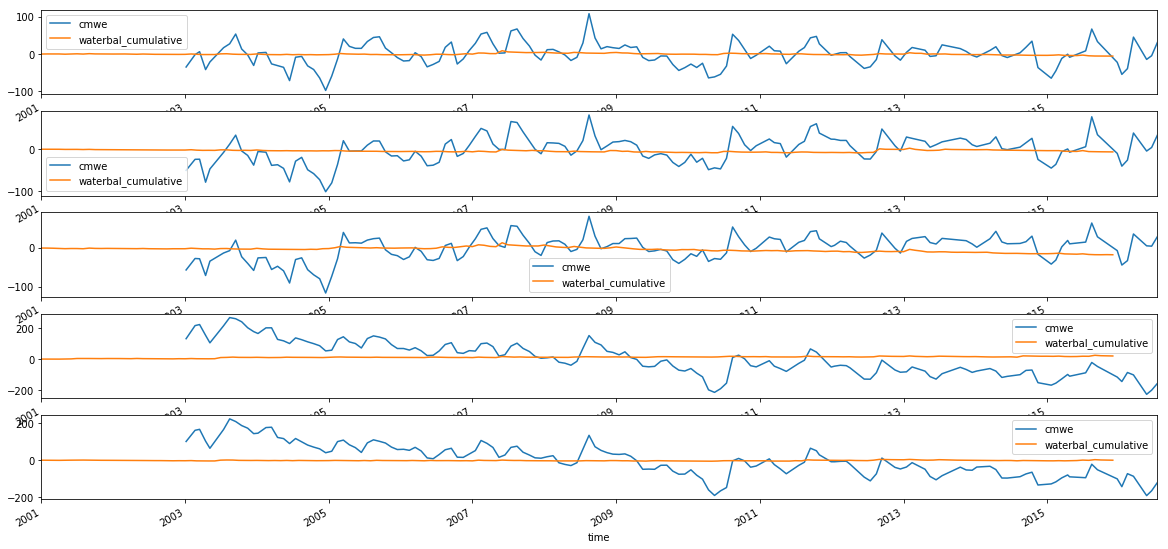

In [15]:
f, ax = plt.subplots(nrows=5, figsize=(20, 10))

for idx, masconid in enumerate(masconsid[:5]):
    # GRACE
    gracedf[gracedf['mascon'] == masconid].plot(ax=ax[idx], y='cmwe')

    # LIS
    lisdf[lisdf['mascon'] == masconid].plot(ax=ax[idx], y='waterbal_cumulative')

## Perform analysis (Whole Region)

In [16]:
grc_all = gracedf
grct = grc_all.groupby('time').sum()

In [22]:
lisdf['waterbal_cumulative_x10'] = lisdf['waterbal_cumulative'].apply(lambda x: x*10)

In [23]:
wctst = lisdf.groupby('time').sum()

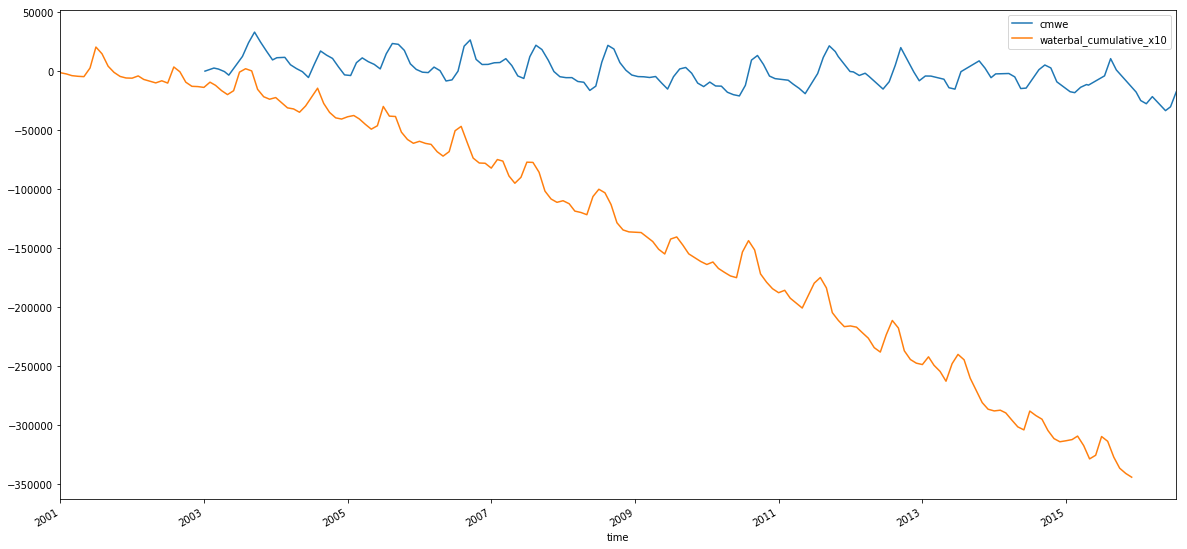

In [24]:
f, ax = plt.subplots(1, figsize=(20, 10))
grct.plot(ax=ax, y='cmwe')
wctst.plot(ax=ax, y='waterbal_cumulative_x10')